### Generates an expert behavior policy to solve LunarLander using a double DQN with Prioritized Experience Replay buffer

In [1]:
# !pip install Box2D
# !pip install 'gym[all]'
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import time
import sys
from tqdm import tqdm
from dqnetwork import DQNetwork
from agent import Agent
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
env_id = 'LunarLander-v2'
env = gym.make(env_id)

In [3]:
env.observation_space #continuous with 8 observations for each state

Box(8,)

In [4]:
env.action_space #discrete with 4 actions

Discrete(4)

### Running an agent using random policy π.

In [5]:
env.reset()
total_reward = 0
for i in range(1000):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    total_reward += reward
    #env.render() #sudo-human
    if(done):
        break
print("Reward: {}\nIteration #: {}\nEnding state:\n{}".format(total_reward, i, state))

Reward: -226.18303588377657
Iteration #: 101
Ending state:
[-0.6700924   0.09227973 -0.15544848  0.12402631  1.490605    0.72833174
  0.          1.        ]


### Implement DQN Agent

In [6]:
agent = Agent()
#To load an agent
# agent.load_model("../../model/policies/behavior_policy_x.pth")

In [7]:
scores = []  # List with all scores per episode
score_d = deque(maxlen=100) #Last 100 episodes
NUM_EPISODES = 5_000
ENV_SOLVED = 145 #How many mean iterations to stay 'alive' in order to succeed?

### Train Agent

In [8]:
def get_epsilon_i(num_episode, epsilon_min = 0.01):
    """Simple Epsilon Decay over total number of episodes. Stochastic in nature when summed over"""
    if(num_episode <= 400): #simulate 400 random episodes
        return 1
    
    epsilon = 1.0/(400 - num_episode)
    return max(epsilon, epsilon_min)

In [9]:
for epoch in range(1, NUM_EPISODES+1):
    env_info = env.reset()   # reset the environment
    state = env.reset()      # get the initial state
    score = 0                # initialize the score
    i = 0
    while True:
        i += 1
        epsilon = get_epsilon_i(epoch)
        action = agent.get_action(state, epsilon)              # select an action
        next_state, reward, done, _ = env.step(action)         # step into next state
        transition = (state, action, reward, next_state, done) # set transition
        agent.step(transition)                                 # Train the model
        score += reward                                        # update the score
        state = next_state                                     # roll over the state to next time step
        if done:                                               # exit loop if episode finished
            break
            
    scores.append(score)
    score_d.append(score)
    
    if(epoch%50 == 0):#Print stats every 50 episodes
        print(f"\r{epoch}: Score: {score}; Last 100 mean: {np.mean(score_d)}; Epsilon: {epsilon}", end="")
    if(np.mean(score_d) >= ENV_SOLVED):
        print(f"\n\nSolved at episode {epoch} with score: {score} and mean: {np.mean(score_d)}")
        break

2050: Score: 132.3259308211115; Last 100 mean: 141.36592343513806; Epsilon: 0.01111

Solved at episode 2055 with score: 164.08872457511984 and mean: 145.54262550126165


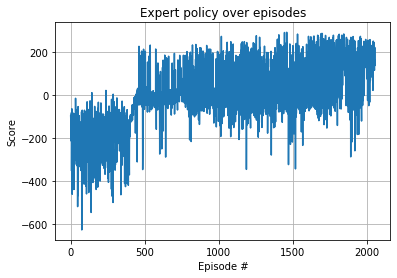

In [10]:
plt.title("Expert policy over episodes")
plt.plot(scores)
plt.xlabel("Episode #")
plt.ylabel("Score")
plt.grid()
plt.show()

In [11]:
#Calculate rolling average
import pandas as pd
df = pd.DataFrame(scores)

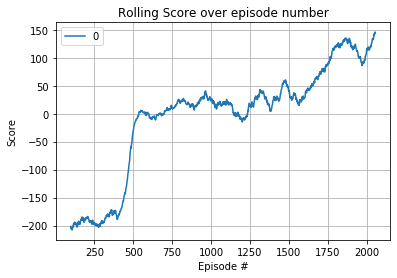

In [12]:
df = df.rolling(window=100).mean()
df.plot()
plt.xlabel("Episode #")
plt.ylabel("Score")
plt.title("Rolling Score over episode number")
plt.grid()
plt.legend()
plt.show()

### Test model

In [13]:
time.sleep(3) #delay
state = env.reset()
total_reward = 0
i = 1
while True:
    action = agent.get_action(state, eps=epsilon)
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state
    i+=1 #increment time-step
    env.render() #sudo-human
    if(done):
        break
print("Reward: {}\nIteration #: {}\nEnding state:\n{}".format(total_reward, i, state))

Reward: 135.3342088430746
Iteration #: 566
Ending state:
[ 0.4847045  -0.08327353  0.          0.          0.19609556  0.
  1.          1.        ]


### Saving policy

In [15]:
#### Save model:
agent.save_model("../../models/evaluation_DQN_policy.pth") #save model

Model saved!
